In [14]:
import pandas as pd
import numpy as np

def zscore(series):
    return (series - series.mean()) / series.std()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

data = pd.read_pickle('Merged_CEX_DEX_v2_p1.pkl')
data.head()

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,price_dex,tcost_usd,time,time_dex,price_cex,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,19.908921
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2281.106770,6.936970,2024-01-01 00:00:59,2024-01-01 00:00:59,2282.69,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,20.441538
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2281.106770,88.043187,2024-01-01 00:01:23,2024-01-01 00:01:23,2281.64,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,20.481472


In [3]:
(data[data['LVR_clean']>data['LVR_clean'].quantile(0.9)]['tcost_usd']/data[data['LVR_clean']>data['LVR_clean'].quantile(0.9)]['amountUSD'])

2        0.000257
3        0.009046
13       0.000116
14       0.003482
15       0.007295
           ...   
59959    0.001452
59961    0.005187
59978    0.818687
59979    0.000445
59980    0.312736
Length: 6000, dtype: float64

<Axes: >

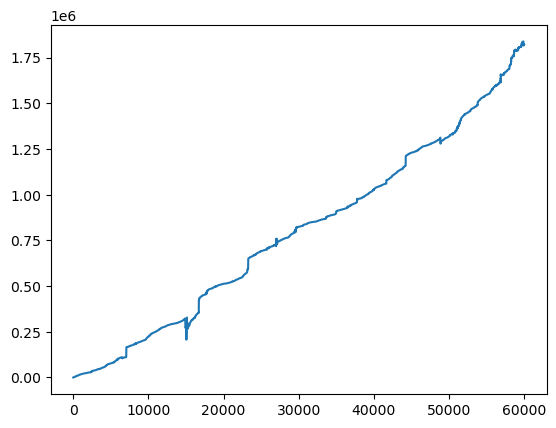

In [4]:
# fees received by LP in USD
# if amount0>0, it is added to the pool and if amount1<0, it is taken from the pool.
fee_receive_quote = data.amount0 + data.amount1 * data.price_dex.shift(1)
fee_receive_quote.cumsum().plot()

<Axes: >

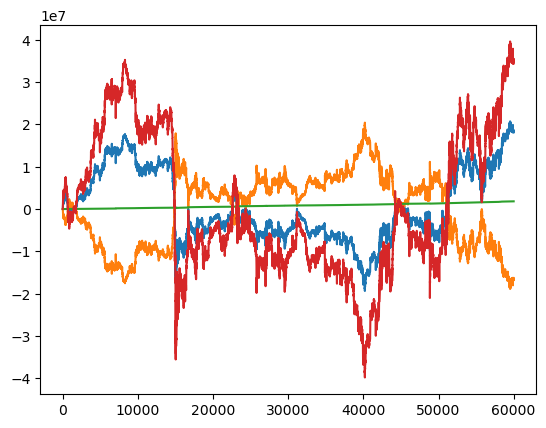

In [5]:
data.amount0.cumsum().plot()
(data.amount1 * data.price_dex.shift(1)).cumsum().plot()
(data.amount0 + data.amount1 * data.price_dex.shift(1)).cumsum().plot()
(data.amount0 - data.amount1 * data.price_dex.shift(1)).cumsum().plot()

<Axes: >

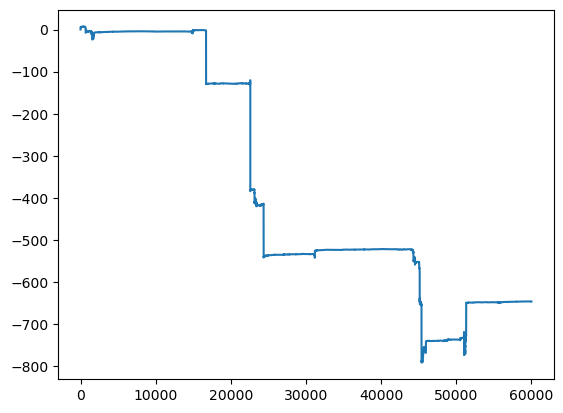

In [6]:
(data.amount0  + data.amount0 ).cumsum().pct_change().cumsum().plot()

<Axes: >

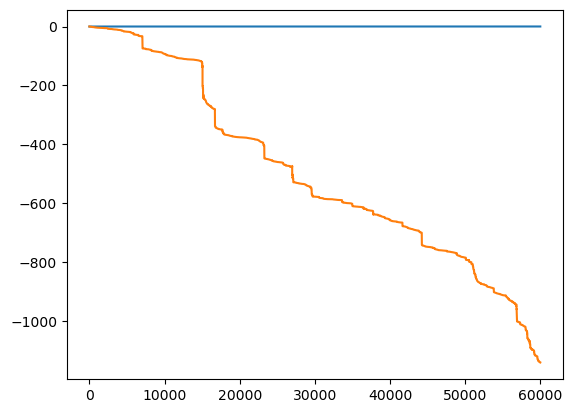

In [7]:
ret_token1 = data.price_dex.pct_change(1)#.shift(1)
ret_pool   = ret_token1 * data.amount1
ret_pool.dropna()

ret_token1.cumsum().plot()
ret_pool.cumsum().plot()

In [19]:
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')

data['LVR_nbtoken']     = data['LVR']/data['price_dex']
data['LVR_pnl_percent'] = (np.abs(data['LVR_clean'] * data['amountUSD']) - data['tcost_usd'])*100 / data['amountUSD']
data['LVR_zscore']      = zscore(data['LVR'])

data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['volumeUSD']       = data['amountUSD'].rolling(100).sum()
data['price_impact']    = data['price_dex'].pct_change(1).shift(-1) # can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount

data['time_diff']           = data['time'].diff().dt.total_seconds().fillna(0)
data['rolling_time_span']   = data['time_diff'].rolling(window=3600, min_periods=1).sum()
data['rolling_trade_count'] = data['time'].rolling(window=3600, min_periods=1).count()
data['lambda'] = data['rolling_trade_count'] / data['rolling_time_span']
data['lambda'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff', 'rolling_time_span', 'rolling_trade_count'])
data

<Axes: >

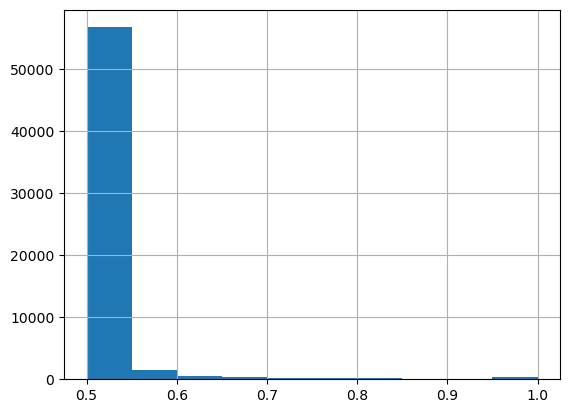

In [25]:
sigmoid(data['tcost_usd']/data['amountUSD']).hist()

In [20]:
data['target_fee'] = sigmoid(data['tcost_usd']/data['amountUSD'])

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm,LVR_nbtoken,LVR_pnl_percent,LVR_zscore,price_impact,mean_rol_amount
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898e+00,-0.001082,31.058511,-0.012213,0.000000,NaN
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399e+00,-0.000042,29.667895,-0.010061,0.000100,NaN
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,1.990892e+01,-0.007604,158.297330,-0.025702,0.000000,NaN
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,2.044154e+01,-0.000233,157.418365,-0.010458,0.000000,NaN
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,2.048147e+01,-0.000018,1.747092,-0.010011,0.000100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,2024-01-11 00:19:46.223,-2.632245,65029.281806,-2.105796,3.739000e+06,-0.000816,260.387510,-0.011884,0.000000,6.724595e+06
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,2024-01-11 00:19:53.335,-2.422245,65031.704050,-3.714334,3.739003e+06,-0.001440,241.379868,-0.013343,-0.000200,6.662888e+06
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,2024-01-11 00:20:02.170,-1.216392,65032.920442,-4.522199,3.739008e+06,-0.001753,121.182189,-0.014075,0.000600,6.668813e+06
59998,50010.837140,-19.375430,50056.125466,0xe4e968b3abe7123f18b318e8ad17ce3826b5cff6,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,332676,4.989490e+10,4.989490e-08,...,2024-01-11 00:20:31.822,-4.454261,65037.374703,86.303211,3.739094e+06,0.033442,445.340477,0.068279,-0.001299,6.686023e+06


In [10]:
# 'origin','sender'
data[['LVR_pnl_percent', 'origin']].groupby('origin').sum()

,LVR_pnl_percent
origin,
0x0000000000211b7cdd33049a9f1985013babb784,227.933460
0x000000000026a1f577dbf53aaf2c82be36dad52e,158.115101
0x00000000006753b3acb0d6f57a11abce4cffc049,167.642743
0x000000000092214e86d0c37795c80807d0ab14dc,188.280430
0x0000000000b3b15e53730ee3042f8b12fc659535,8.786646
...,...
0xffeccfec9c710f3d51876d0c4a0e7920fd4856d8,156.178062
0xfff2c305b277879cc2e9c273632e9523ed99cdde,219.482007
0xfffa84476428be3370be2802b6e0fad24d9fe833,74.419108


array([[<Axes: title={'center': 'LVR_pnl_percent'}>]], dtype=object)

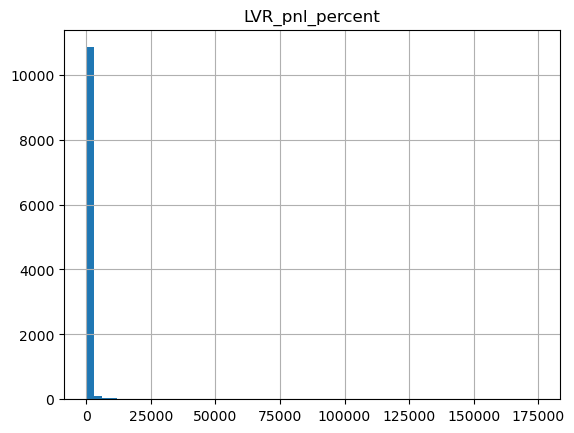

In [11]:
tmp = (data[['LVR_pnl_percent', 'origin']].groupby('origin').sum()>100).reset_index()
abritrageur_address_list = tmp[tmp['LVR_pnl_percent'] == True].origin.values
len(abritrageur_address_list)
filtered_data = data[data['origin'].isin(abritrageur_address_list)]
filtered_data[['LVR_pnl_percent', 'origin']].groupby('origin').sum().hist(bins=60)

In [12]:
data[['LVR_zscore', 'origin']]

,LVR_zscore,origin
0,-0.012213,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84
1,-0.010061,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503
2,-0.025702,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0
3,-0.010458,0xc10527cdbc055b7f9a8a4ad765b287190c861c51
4,-0.010011,0xf468072ca8f81e11655c252a37317e814b24872b
...,...,...
59995,-0.011884,0xca74f404e0c7bfa35b13b511097df966d5a65597
59996,-0.013343,0x475d2c6f6a46a83d1781e61500d1c540f85fd721
59997,-0.014075,0xeef68d213fbbf6f01235a6c1318f82a1692c01de
59998,0.068279,0xe4e968b3abe7123f18b318e8ad17ce3826b5cff6


In [13]:
tmp = (data[['LVR_pnl_percent', 'sender']].groupby('sender').sum()>100).reset_index()
abritrageur_address_list = tmp[tmp['LVR_pnl_percent'] == True].sender.values
print(len(abritrageur_address_list))
filtered_data = data[data['sender'].isin(abritrageur_address_list)]
t = data[['LVR_pnl_percent', 'sender']].groupby('sender').sum().apply(lambda x : sigmoid(x))

201


/Users/armandmorin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
data[['LVR_pnl_percent', 'sender']].groupby('sender').sum()
data[['LVR_pnl_percent', 'origin']].groupby('origin').sum()

,LVR_pnl_percent
origin,
0x0000000000211b7cdd33049a9f1985013babb784,227.933460
0x000000000026a1f577dbf53aaf2c82be36dad52e,158.115101
0x00000000006753b3acb0d6f57a11abce4cffc049,167.642743
0x000000000092214e86d0c37795c80807d0ab14dc,188.280430
0x0000000000b3b15e53730ee3042f8b12fc659535,8.786646
...,...
0xffeccfec9c710f3d51876d0c4a0e7920fd4856d8,156.178062
0xfff2c305b277879cc2e9c273632e9523ed99cdde,219.482007
0xfffa84476428be3370be2802b6e0fad24d9fe833,74.419108


In [15]:
# methodology:
# Take a rolling windows of the past 1 million tx for instance
# Perform all the signle trades analysis, in term of pnl anf LVR percent
# Aggregate the metrics to get the trader perfs 
# Charge the fee per trader

import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def fee_pnl(LVR_pnl_percent):
    # output is in 100%
    coef = 1
    return sigmoid(LVR_pnl_percent / 250) * coef

def fee_base(LVR_zscore):
    # output is in 100%
    base_pool_fee = 0.05
    coef = 1.03
    return coef * sigmoid(base_pool_fee + LVR_zscore * 0.03)

agg_sender = data[['LVR_pnl_percent', 'LVR_zscore', 'sender']].groupby('sender').sum()
agg_origin = data[['LVR_pnl_percent', 'LVR_zscore', 'origin']].groupby('origin').sum()
agg_recipient = data[['LVR_pnl_percent', 'LVR_zscore', 'recipient']].groupby('recipient').sum()

dico_percent = {}
dico_zscore = {}

for df in [agg_sender, agg_origin, agg_recipient]:
    for address, lvr_percent, lvr_zscore in zip(df.index, df['LVR_pnl_percent'], df['LVR_zscore']):
        if address in dico_percent:
            dico_percent[address] += lvr_percent
            dico_zscore[address] += lvr_zscore
        else:
            dico_percent[address] = lvr_percent
            dico_zscore[address] = lvr_zscore


# filter addresses trading with positive LVR return 
dic_base_fee = {address: fee_base(LVR_zscore) for address, LVR_zscore in dico_zscore.items() if LVR_zscore > 0}

dic_fee       = {address: fee_pnl(LVR_pnl_percent) for address, LVR_pnl_percent in dico_percent.items() if LVR_pnl_percent > 0 }

merged_dict = {key: dic_fee.get(key, 0) + dic_base_fee.get(key, 0) for key in set(dic_fee) | set(dic_base_fee)}

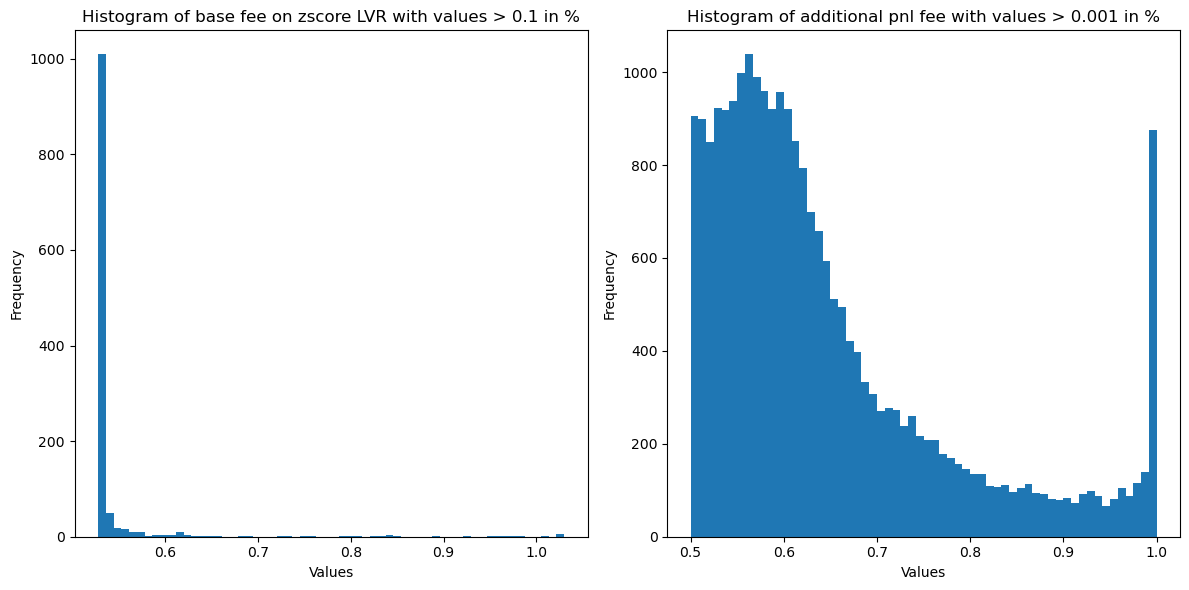

In [16]:
import matplotlib.pyplot as plt

# Filter values greater than threshold in %
threshold_base = 0.1
threshold_fees = 0.001
filtered_base_values = [value for value in dic_base_fee.values() if value > threshold_base]
filtered_fee_values = [value for value in dic_fee.values() if value > threshold_fees]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(filtered_base_values, bins=60)
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Histogram of base fee on zscore LVR with values > {threshold_base} in %')

ax2.hist(filtered_fee_values, bins=60)
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Histogram of additional pnl fee with values > {threshold_fees} in %')

plt.tight_layout()
plt.show()


In [17]:
please.reset_index().rename(columns={'index': 'address'}).sort_values(by='fees', ascending=False)

NameError: name 'please' is not defined

In [ ]:
please = pd.DataFrame.from_dict(merged_dict, orient='index', columns=['fees'])
please = please.reset_index().rename(columns={'index': 'address'}).sort_values(by='fees', ascending=False)

merged_data = data.merge(please.rename(columns={'fees' : 'f1'}), left_on='sender', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f2'}), left_on='origin', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f3'}), left_on='recipient', how='left', right_on='address')

merged_data[['f1', 'f2', 'f3']] = merged_data[['f1', 'f2', 'f3']].fillna(0).clip(lower=0.05)

merged_data['mean_fee'] = merged_data[['f1', 'f2', 'f3']].mean(axis=1) 
#merged_data['max_fee']  = merged_data[['f1', 'f2', 'f3']].max(axis=1) 

merged_data = merged_data.drop(columns=['address_x', 'address_y', 'address', 'f1', 'f2', 'f3']).fillna(0.5)

merged_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm,LVR_nbtoken,LVR_pnl_percent,LVR_zscore,mean_fee,max_fee
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898e+00,-0.001082,31.058511,-0.012213,0.366667,1.000000
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399e+00,-0.000042,29.667895,-0.010061,0.209878,0.529633
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,1.990892e+01,-0.007604,158.297330,-0.025702,1.175693,1.527080
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,2.044154e+01,-0.000233,157.418365,-0.010458,0.906057,1.000000
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,2.048147e+01,-0.000018,1.747092,-0.010011,0.050000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,2024-01-11 00:19:46.223,-2.632245,65029.281806,-2.105796,3.739000e+06,-0.000816,260.387510,-0.011884,1.000000,1.000000
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,2024-01-11 00:19:53.335,-2.422245,65031.704050,-3.714334,3.739003e+06,-0.001440,241.379868,-0.013343,0.915576,1.000000
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,2024-01-11 00:20:02.170,-1.216392,65032.920442,-4.522199,3.739008e+06,-0.001753,121.182189,-0.014075,0.598821,0.873232
59998,50010.837140,-19.375430,50056.125466,0xe4e968b3abe7123f18b318e8ad17ce3826b5cff6,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,332676,4.989490e+10,4.989490e-08,...,2024-01-11 00:20:31.822,-4.454261,65037.374703,86.303211,3.739094e+06,0.033442,445.340477,0.068279,0.494755,1.384264


In [ ]:
(merged_data['mean_fee'] * merged_data['amountUSD']/100).sum()

29646230.103912454

In [ ]:
merged_data['LVR'].sum()

660046.1473910192